# Project : Predicting Breast Cancer Survival Using Machine Learning and the METABRIC Dataset

> By Student Group : AAI-501 - Group 5

## Import packages and Setting up global options

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import joblib
pd.options.display.max_columns=None
pd.options.display.max_rows=None
pd.options.display.max_colwidth=None
pd.options.display.float_format='{:.3f}'.format

## Read data and set index for primary column (patient id)

In [2]:
print('Reading data ... ')
data = pd.read_csv("./Dataset/METABRIC_RNA_Mutation.csv", engine="python")
print('Shape of the original data is :' , data.shape)

# Setting the patient_id column as index for better handling of data
data.reset_index(drop=True, inplace=True)
data.set_index('patient_id',inplace=True)

# Drop death_from_cancer column as it represents the same column as overall_survival
data.drop('death_from_cancer', axis=1, inplace=True)
print('Shape after removing the repeated column death_from_cancer is :' , data.shape)

Reading data ... 
Shape of the original data is : (1904, 693)
Shape after removing the repeated column death_from_cancer is : (1904, 691)


In [3]:
# Examine sample record
data.sample()
print('Observation: There are -\n1 target column overall_survival\n12 numeric columns, \
      \n16 categorical columns (including binary), \n489 numeric gene mRNA levels columns and \
      \n173 numeric gene mutation level columns')
print('\nPlan : Include 12 numeric + 16 categorical and 489 numeric gene mRNA expression level features where \
      \n1) numeric features will be considered as it is\
      \n2) categorical features to be encoded by onehotencoding\
      \n3) gene mRNA expression levels features to be reduced to 10 by Principal Component Analysis')

Observation: There are -
1 target column overall_survival
12 numeric columns,       
16 categorical columns (including binary), 
489 numeric gene mRNA levels columns and       
173 numeric gene mutation level columns

Plan : Include 12 numeric + 16 categorical and 489 numeric gene mRNA expression level features where       
1) numeric features will be considered as it is      
2) categorical features to be encoded by onehotencoding      
3) gene mRNA expression levels features to be reduced to 10 by Principal Component Analysis


In [4]:
# Clean the column integrative cluster to treat as numeric variable for better understanding
data['integrative_cluster']=np.where(data['integrative_cluster'].isin(['4ER+','4ER-']),4,data['integrative_cluster'])

In [5]:
# Convert the column tumor_stage to categorical to handle high missing %
data['tumor_stage']=np.select([data['tumor_stage']==0,data['tumor_stage']==1,data['tumor_stage']==2,data['tumor_stage']==3,data['tumor_stage']==4],
                              ['stage_0','stage_1','stage_2','stage_3','stage_4'],default='unknown')

In [6]:
# Seggregate the columns into different categories
num_cols=['age_at_diagnosis', 'integrative_cluster', 'chemotherapy', 'cohort', 'neoplasm_histologic_grade', 'hormone_therapy', 'lymph_nodes_examined_positive', 'mutation_count', 'nottingham_prognostic_index', 'overall_survival_months', 'radio_therapy', 'tumor_size']
cat_cols=['tumor_stage', 'type_of_breast_surgery', 'cancer_type', 'cancer_type_detailed', 'cellularity', 'pam50_+_claudin-low_subtype', 'er_status_measured_by_ihc', 'er_status', 'her2_status_measured_by_snp6', 'her2_status', 'tumor_other_histologic_subtype', 'inferred_menopausal_state', 'primary_tumor_laterality', 'oncotree_code', 'pr_status', '3-gene_classifier_subtype']
target=['overall_survival']
gene_mrna=['brca1', 'brca2', 'palb2', 'pten', 'tp53', 'atm', 'cdh1', 'chek2', 'nbn', 'nf1', 'stk11', 
           'bard1', 'mlh1', 'msh2', 'msh6', 'pms2', 'epcam', 'rad51c', 'rad51d', 'rad50', 'rb1', 'rbl1', 
           'rbl2', 'ccna1', 'ccnb1', 'cdk1', 'ccne1', 'cdk2', 'cdc25a', 'ccnd1', 'cdk4', 'cdk6', 'ccnd2', 
           'cdkn2a', 'cdkn2b', 'myc', 'cdkn1a', 'cdkn1b', 'e2f1', 'e2f2', 'e2f3', 'e2f4', 'e2f5', 'e2f6', 
           'e2f7', 'e2f8', 'src', 'jak1', 'jak2', 'stat1', 'stat2', 'stat3', 'stat5a', 'stat5b', 'mdm2', 
           'tp53bp1', 'adam10', 'adam17', 'aph1a', 'aph1b', 'arrdc1', 'cir1', 'ctbp1', 'ctbp2', 'cul1', 
           'dll1', 'dll3', 'dll4', 'dtx1', 'dtx2', 'dtx3', 'dtx4', 'ep300', 'fbxw7', 'hdac1', 'hdac2', 
           'hes1', 'hes5', 'heyl', 'itch', 'jag1', 'jag2', 'kdm5a', 'lfng', 'maml1', 'maml2', 'maml3', 
           'ncor2', 'ncstn', 'notch1', 'notch2', 'notch3', 'nrarp', 'numb', 'numbl', 'psen1', 'psen2', 
           'psenen', 'rbpj', 'rbpjl', 'rfng', 'snw1', 'spen', 'hes2', 'hes4', 'hes7', 'hey1', 'hey2', 
           'acvr1', 'acvr1b', 'acvr1c', 'acvr2a', 'acvr2b', 'acvrl1', 'akt1', 'akt1s1', 'akt2', 'apaf1', 
           'arl11', 'atr', 'aurka', 'bad', 'bcl2', 'bcl2l1', 'bmp10', 'bmp15', 'bmp2', 'bmp3', 'bmp4', 
           'bmp5', 'bmp6', 'bmp7', 'bmpr1a', 'bmpr1b', 'bmpr2', 'braf', 'casp10', 'casp3', 'casp6', 
           'casp7', 'casp8', 'casp9', 'chek1', 'csf1', 'csf1r', 'cxcl8', 'cxcr1', 'cxcr2', 'dab2', 'diras3', 
           'dlec1', 'dph1', 'egfr', 'eif4e', 'eif4ebp1', 'eif5a2', 'erbb2', 'erbb3', 'erbb4', 'fas', 'fgf1', 
           'fgfr1', 'folr1', 'folr2', 'folr3', 'foxo1', 'foxo3', 'gdf11', 'gdf2', 'gsk3b', 'hif1a', 'hla-g', 
           'hras', 'igf1', 'igf1r', 'inha', 'inhba', 'inhbc', 'itgav', 'itgb3', 'izumo1r', 'kdr', 'kit', 
           'kras', 'map2k1', 'map2k2', 'map2k3', 'map2k4', 'map2k5', 'map3k1', 'map3k3', 'map3k4', 'map3k5', 
           'mapk1', 'mapk12', 'mapk14', 'mapk3', 'mapk4', 'mapk6', 'mapk7', 'mapk8', 'mapk9', 'mdc1', 'mlst8', 
           'mmp1', 'mmp10', 'mmp11', 'mmp12', 'mmp13', 'mmp14', 'mmp15', 'mmp16', 'mmp17', 'mmp19', 'mmp2', 
           'mmp21', 'mmp23b', 'mmp24', 'mmp25', 'mmp26', 'mmp27', 'mmp28', 'mmp3', 'mmp7', 'mmp9', 'mtor', 
           'nfkb1', 'nfkb2', 'opcml', 'pdgfa', 'pdgfb', 'pdgfra', 'pdgfrb', 'pdpk1', 'peg3', 'pik3ca', 
           'pik3r1', 'pik3r2', 'plagl1', 'ptk2', 'rab25', 'rad51', 'raf1', 'rassf1', 'rheb', 'rictor', 
           'rps6', 'rps6ka1', 'rps6ka2', 'rps6kb1', 'rps6kb2', 'rptor', 'slc19a1', 'smad1', 'smad2', 
           'smad3', 'smad4', 'smad5', 'smad6', 'smad7', 'smad9', 'sptbn1', 'terc', 'tert', 'tgfb1', 'tgfb2', 
           'tgfb3', 'tgfbr1', 'tgfbr2', 'tgfbr3', 'tsc1', 'tsc2', 'vegfa', 'vegfb', 'wfdc2', 'wwox', 'zfyve9', 
           'arid1a', 'arid1b', 'cbfb', 'gata3', 'kmt2c', 'kmt2d', 'myh9', 'ncor1', 'pde4dip', 'ptprd', 'ros1', 
           'runx1', 'tbx3', 'abcb1', 'abcb11', 'abcc1', 'abcc10', 'bbc3', 'bmf', 'cyp2c8', 'cyp3a4', 'fgf2', 
           'fn1', 'map2', 'map4', 'mapt', 'nr1i2', 'slco1b3', 'tubb1', 'tubb4a', 'tubb4b', 'twist1', 'adgra2', 
           'afdn', 'aff2', 'agmo', 'agtr2', 'ahnak', 'ahnak2', 'akap9', 'alk', 'apc', 'arid2', 'arid5b', 
           'asxl1', 'asxl2', 'bap1', 'bcas3', 'birc6', 'cacna2d3', 'ccnd3', 'chd1', 'clk3', 'clrn2', 'col12a1', 
           'col22a1', 'col6a3', 'ctcf', 'ctnna1', 'ctnna3', 'dnah11', 'dnah2', 'dnah5', 'dtwd2', 'fam20c', 
           'fanca', 'fancd2', 'flt3', 'foxp1', 'frmd3', 'gh1', 'gldc', 'gpr32', 'gps2', 'hdac9', 'herc2', 
           'hist1h2bc', 'kdm3a', 'kdm6a', 'klrg1', 'l1cam', 'lama2', 'lamb3', 'large1', 'ldlrap1', 'lifr', 
           'lipi', 'magea8', 'map3k10', 'map3k13', 'men1', 'mtap', 'muc16', 'myo1a', 'myo3a', 'ncoa3', 'nek1', 
           'nf2', 'npnt', 'nr2f1', 'nr3c1', 'nras', 'nrg3', 'nt5e', 'or6a2', 'palld', 'pbrm1', 'ppp2cb', 
           'ppp2r2a', 'prkacg', 'prkce', 'prkcq', 'prkcz', 'prkg1', 'prps2', 'prr16', 'ptpn22', 'ptprm', 
           'rasgef1b', 'rpgr', 'ryr2', 'sbno1', 'setd1a', 'setd2', 'setdb1', 'sf3b1', 'sgcd', 'shank2', 
           'siah1', 'sik1', 'sik2', 'smarcb1', 'smarcc1', 'smarcc2', 'smarcd1', 'spaca1', 'stab2', 'stmn2', 
           'syne1', 'taf1', 'taf4b', 'tbl1xr1', 'tg', 'thada', 'thsd7a', 'ttyh1', 'ubr5', 'ush2a', 'usp9x', 
           'utrn', 'zfp36l1', 'ackr3', 'akr1c1', 'akr1c2', 'akr1c3', 'akr1c4', 'akt3', 'ar', 'bche', 'cdk8', 
           'cdkn2c', 'cyb5a', 'cyp11a1', 'cyp11b2', 'cyp17a1', 'cyp19a1', 'cyp21a2', 'cyp3a43', 'cyp3a5', 
           'cyp3a7', 'ddc', 'hes6', 'hsd17b1', 'hsd17b10', 'hsd17b11', 'hsd17b12', 'hsd17b13', 'hsd17b14', 
           'hsd17b2', 'hsd17b3', 'hsd17b4', 'hsd17b6', 'hsd17b7', 'hsd17b8', 'hsd3b1', 'hsd3b2', 'hsd3b7', 
           'mecom', 'met', 'ncoa2', 'nrip1', 'pik3r3', 'prkci', 'prkd1', 'ran', 'rdh5', 'sdc4', 'serpini1', 
           'shbg', 'slc29a1', 'sox9', 'spry2', 'srd5a1', 'srd5a2', 'srd5a3', 'st7', 'star', 'tnk2', 'tulp4', 
           'ugt2b15', 'ugt2b17', 'ugt2b7']

In [7]:
# Change datatypes with respective column information
data[num_cols]=data[num_cols].apply(pd.to_numeric, errors='coerce')
data[cat_cols]=data[cat_cols].astype('category')
data[gene_mrna]=data[gene_mrna].apply(pd.to_numeric, errors='coerce')
data['overall_survival']=pd.to_numeric(data['overall_survival'], errors='coerce')

In [8]:
# Examine the different levels in each categorical column
display(data[cat_cols].apply(pd.unique).reset_index())

,index,0
0,tumor_stage,"['stage_2', 'stage_1', 'stage_4', 'stage_3', 'unknown', 'stage_0'] Categories (6, object): ['stage_0', 'stage_1', 'stage_2', 'stage_3', 'stage_4', 'unknown']"
1,type_of_breast_surgery,"['MASTECTOMY', 'BREAST CONSERVING', NaN] Categories (2, object): ['BREAST CONSERVING', 'MASTECTOMY']"
2,cancer_type,"['Breast Cancer', 'Breast Sarcoma'] Categories (2, object): ['Breast Cancer', 'Breast Sarcoma']"
3,cancer_type_detailed,"['Breast Invasive Ductal Carcinoma', 'Breast Mixed Ductal and Lobular Carcinoma', 'Breast Invasive Lobular Carcinoma', 'Breast Invasive Mixed Mucinous Carcinoma', 'Breast', NaN, 'Metaplastic Breast Cancer'] Categories (6, object): ['Breast', 'Breast Invasive Ductal Carcinoma', 'Breast Invasive Lobular Carcinoma', 'Breast Invasive Mixed Mucinous Carcinoma', 'Breast Mixed Ductal and Lobular Carcinoma', 'Metaplastic Breast Cancer']"
4,cellularity,"[NaN, 'High', 'Moderate', 'Low'] Categories (3, object): ['High', 'Low', 'Moderate']"
5,pam50_+_claudin-low_subtype,"['claudin-low', 'LumA', 'LumB', 'Her2', 'Normal', 'Basal', 'NC'] Categories (7, object): ['Basal', 'Her2', 'LumA', 'LumB', 'NC', 'Normal', 'claudin-low']"
6,er_status_measured_by_ihc,"['Positve', 'Negative', NaN] Categories (2, object): ['Negative', 'Positve']"
7,er_status,"['Positive', 'Negative'] Categories (2, object): ['Negative', 'Positive']"
8,her2_status_measured_by_snp6,"['NEUTRAL', 'LOSS', 'GAIN', 'UNDEF'] Categories (4, object): ['GAIN', 'LOSS', 'NEUTRAL', 'UNDEF']"
9,her2_status,"['Negative', 'Positive'] Categories (2, object): ['Negative', 'Positive']"


Issue: These variables provide different names or classifications for cancer type but essentially convey the same information.

Solution: Only one of these variables should be included in the model to avoid redundancy.

## Data Visualisation

The below graphs shows the distribution of key clinical variables for patients who survived vs who did not survived

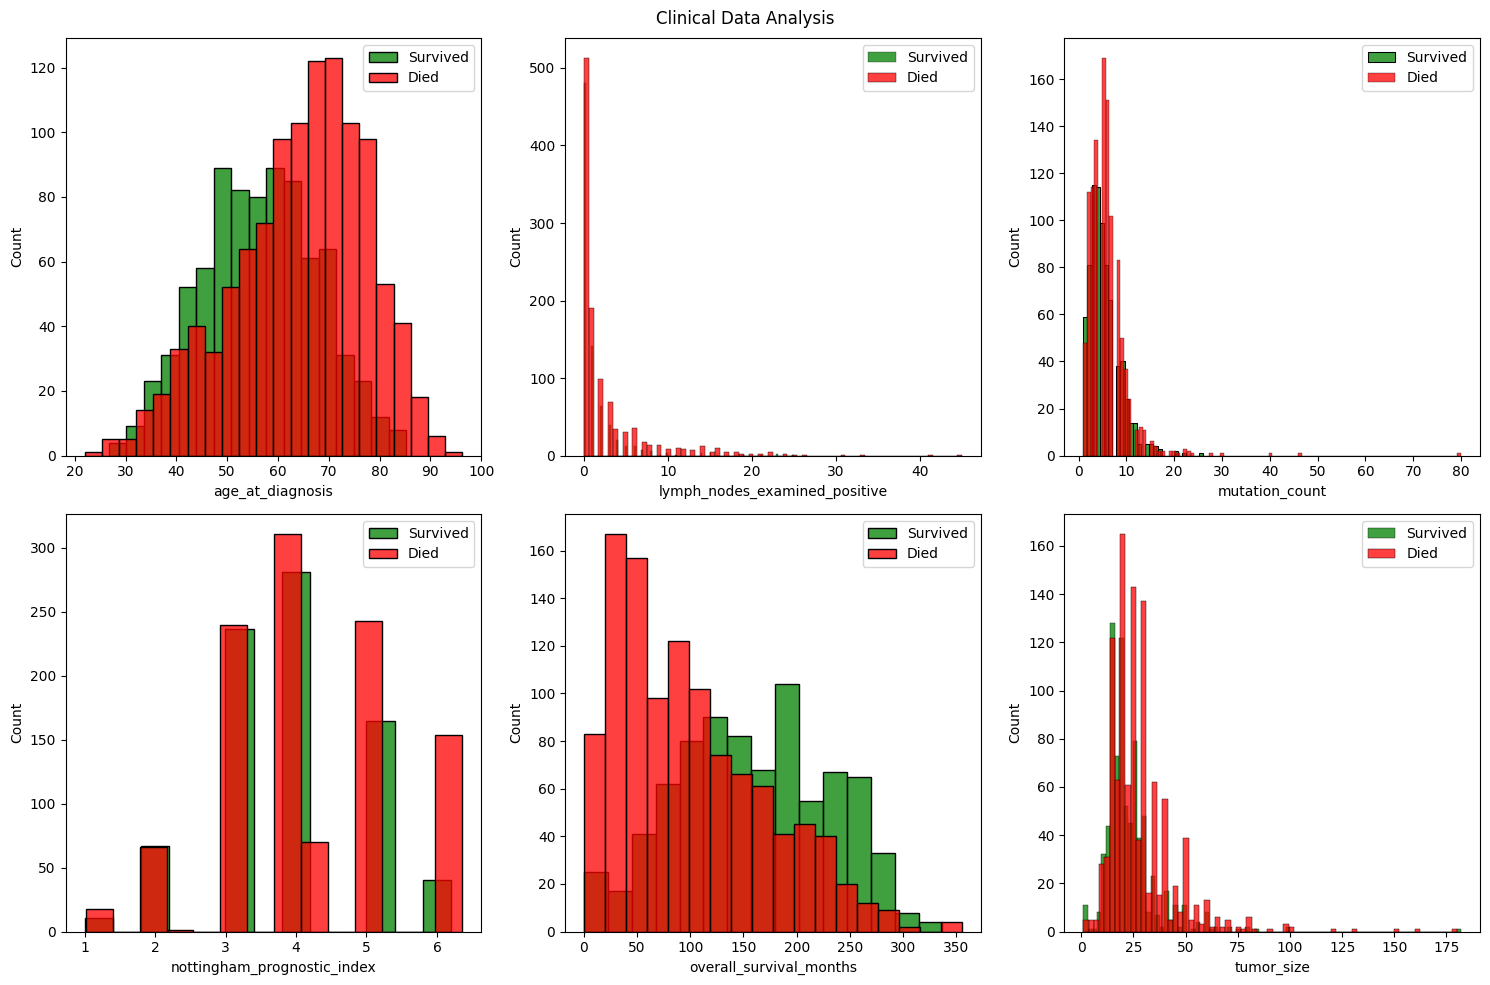

In [9]:
columns = ['age_at_diagnosis', 'lymph_nodes_examined_positive','mutation_count','nottingham_prognostic_index', 'overall_survival_months', 'tumor_size' ]   
fig, axs = plt.subplots(2, 3, figsize=(15, 10))
fig.suptitle('Clinical Data Analysis')
    
# sns.set(style="whitegrid")

for i,ax in zip(data[columns].columns,axs.flatten()):
    sns.histplot(data[i][data['overall_survival']==1], color='g', label = 'Survived',ax=ax)
    sns.histplot(data[i][data['overall_survival']==0], color='r', label = 'Died',ax=ax)
    ax.legend(loc='best')
plt.tight_layout()
plt.show()

1. age at diagnosis: 
    * survivors tend to be younger, with peak between 40-60 years
    * higher mortality in older patients (age > 60 years)
2. lymph_nodes_examined_positive:
    * with an increase in the positive lymph nodes the mortality rate is higher than the survival rate
    * survivors also tends to have fewer lymph nodes than those died 
3. mutation_count:
    * higher mutation appears to correlate with increased mortality
4. nottingham_prognostic_index
    * Patients with lower NPI (<4) tend to survive more
5. overall_survival_months
    * Non-survivors have shorter survival periods (mostly <100 months)
    * Survivors show a wider range, with many living beyond 150+ months
6. tumor_size
    * Small tumors (<50mm) are more common in survivors
    * Larger tumors correlate with increased mortality

### Expression levels of different genes vs survival rates
The below graphs shows the distribution of gene mutation values for different genes, categorized by survival status.

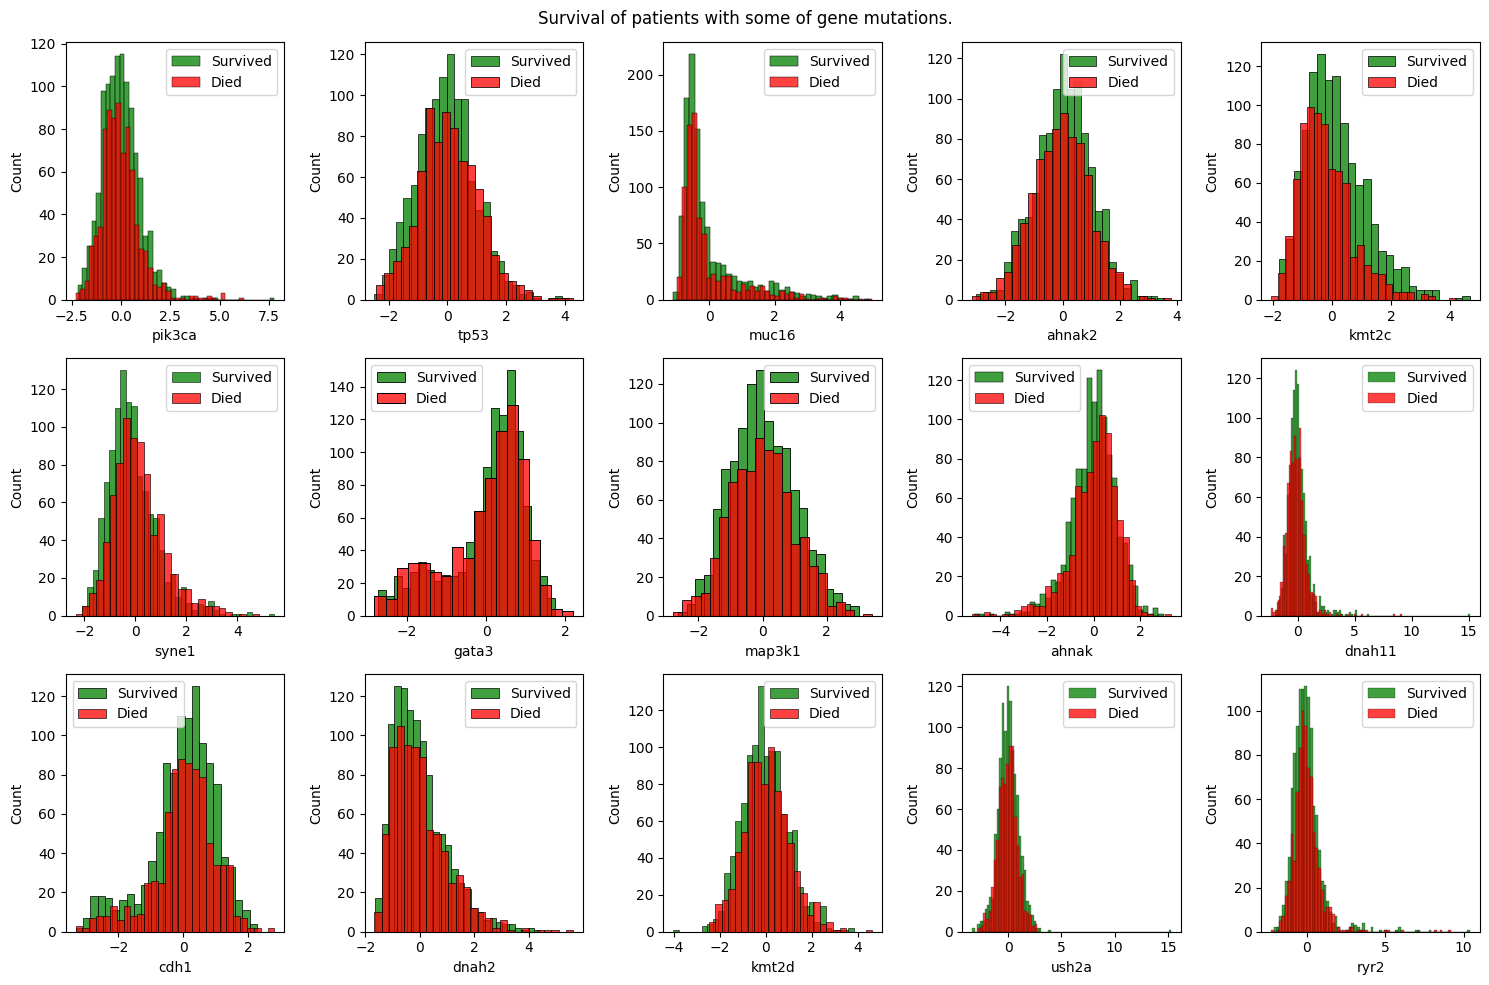

In [10]:
columns = ['pik3ca','tp53','muc16','ahnak2','kmt2c','syne1','gata3','map3k1','ahnak','dnah11','cdh1','dnah2','kmt2d','ush2a','ryr2']   
fig, axs = plt.subplots(3, 5, figsize=(15, 10))
fig.suptitle('Survival of patients with some of gene mutations.')

for i,ax in zip(data[columns].columns,axs.flatten()):
    sns.histplot(data[i][data['overall_survival']==0], color='g', label = 'Survived',ax=ax)
    sns.histplot(data[i][data['overall_survival']==1], color='r', label = 'Died',ax=ax)
    ax.legend(loc='best')
plt.tight_layout()
plt.show()

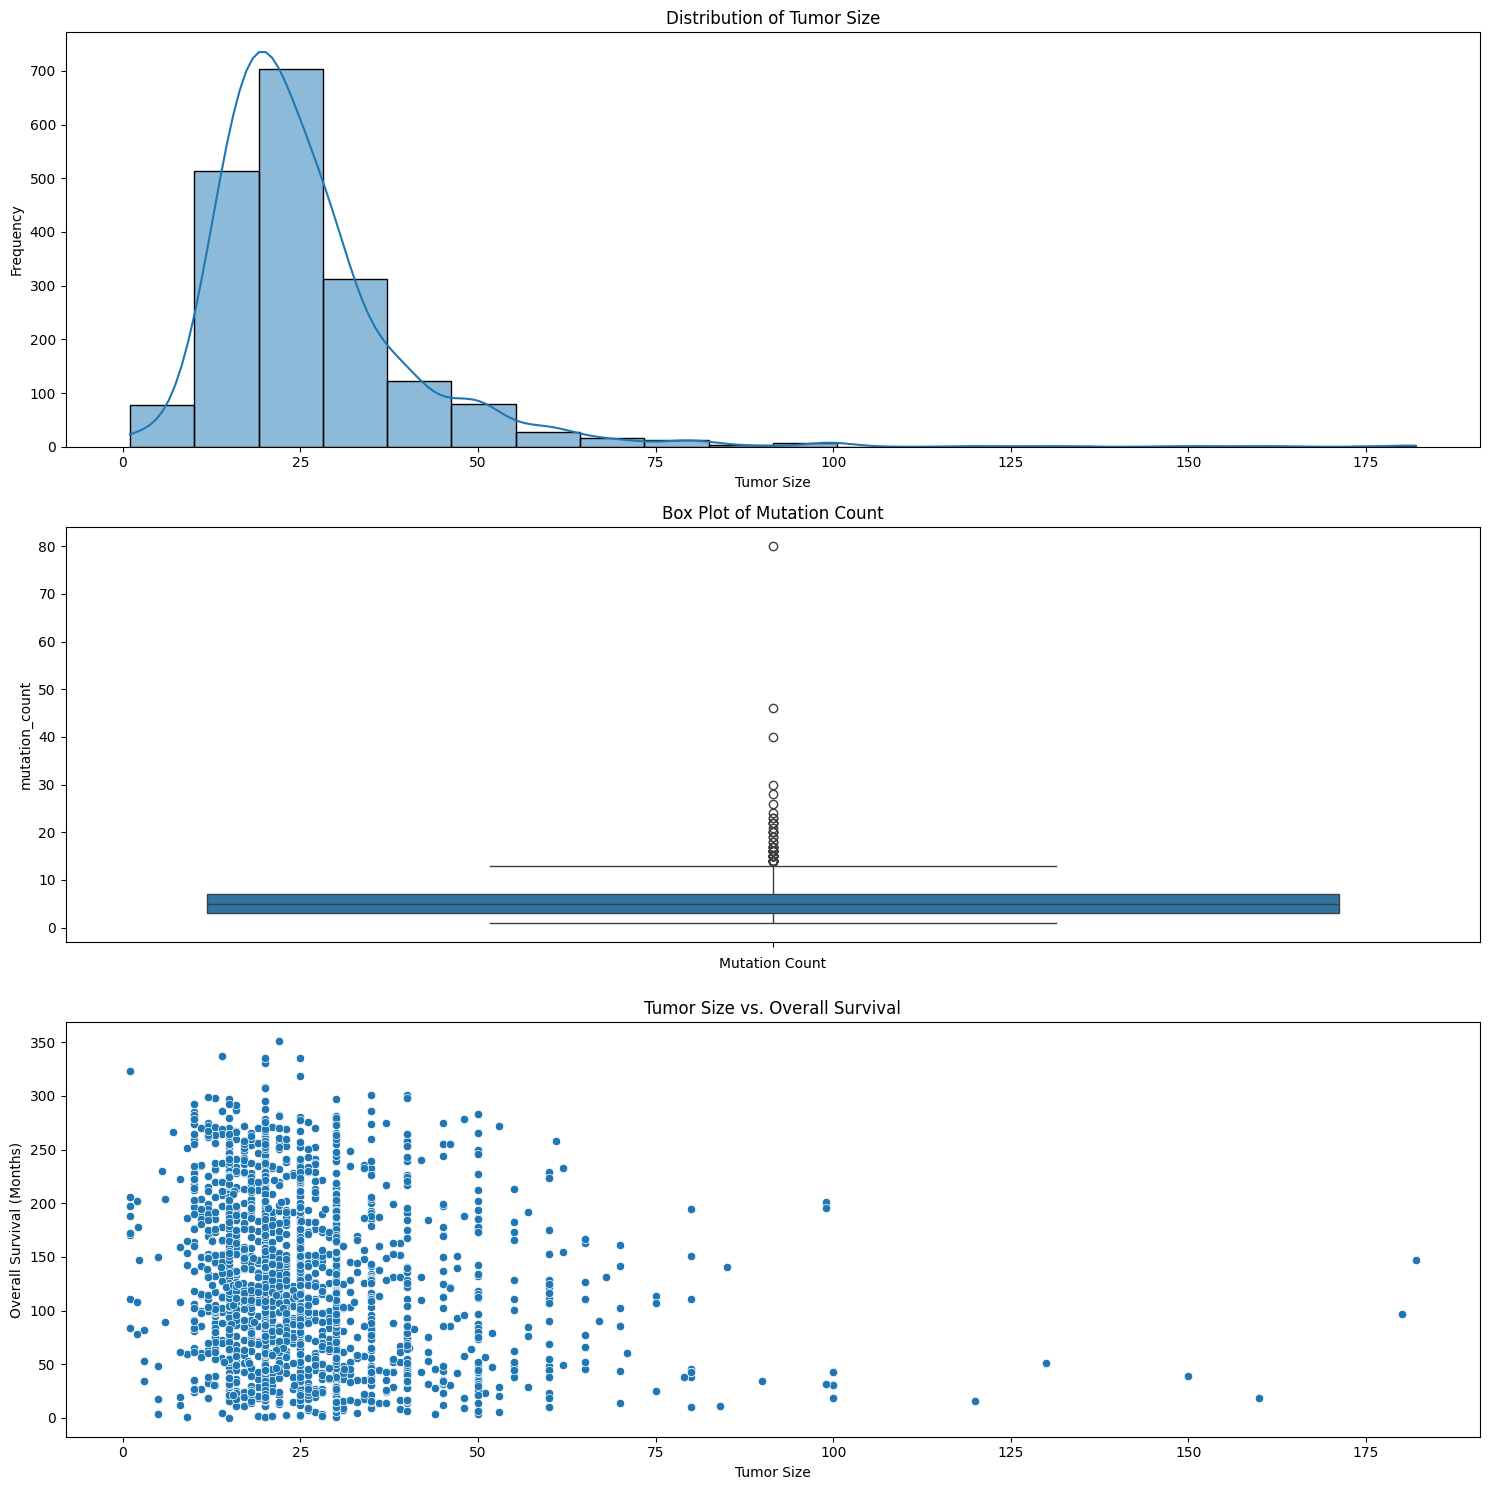

In [11]:
fig, axes = plt.subplots(3,1, figsize=(15, 15))
sns.histplot(data['tumor_size'], bins=20, kde=True, ax=axes[0])
axes[0].set_title('Distribution of Tumor Size')
axes[0].set_xlabel('Tumor Size')
axes[0].set_ylabel('Frequency')


sns.boxplot(data['mutation_count'], ax=axes[1])
axes[1].set_title('Box Plot of Mutation Count')
axes[1].set_xlabel('Mutation Count')

sns.scatterplot(data=data, x='tumor_size', y='overall_survival_months', ax=axes[2])
# sns.boxplot(x='tumor_size', y='overall_survival_months', data=data, ax=axes[2])
axes[2].set_title('Tumor Size vs. Overall Survival')
axes[2].set_xlabel('Tumor Size')
axes[2].set_ylabel('Overall Survival (Months)')
plt.tight_layout()
plt.show()

**1. Distribution of tumor size**
* The histogram shows that most tumor sizes are in the range of 10-40
* There is a right-skewed distribution, meaning a few patients have very large tumors<br>
**Conclusion**
* Most patients have tumors in the lower size range, but there are a few cases with exceptionally large tumors
  
**2. From the box plot of mutation count**
* Q1 = 3
* Q2 = 5
* Q3 = 7
* top whisker is at (Q3 + 1.5(IQR) = 13)
* lower whisker is at (Q1 - 1.5(IQR) = -3, since mutation count cannot be -ve , so lower whisker is at 0)<br>
  **Conclusion**
* the outliers at the top indicate that some individuals have an unusually high mutation count compared to the majority of the data
* This suggests that while most individuals have mutation counts within a normal range (0–13), some have extreme values, possibly due to genetic factors, environmental influences, or errors in data collection

**3. Tumor size vs survival**
* The points are widely scattered
* Patients with small tumors (tumor size < 50) show a wide range of survival times (from very short to over 300 months)
* Some smaller tumors have low survival, while some larger tumors have high survival
* Some tumor sizes have a high variation in survival times, Some patients with the same tumor size live a short time, while others live much longer <br>
**Conclusion**
* Tumor size alone is not a perfect predictor of survival
* Other factors, like mutation count, treatment response, and patient health, likely influence survival

    

In [12]:
data.describe()

,age_at_diagnosis,chemotherapy,cohort,neoplasm_histologic_grade,hormone_therapy,integrative_cluster,lymph_nodes_examined_positive,mutation_count,nottingham_prognostic_index,overall_survival_months,overall_survival,radio_therapy,tumor_size,brca1,brca2,palb2,pten,tp53,atm,cdh1,chek2,nbn,nf1,stk11,bard1,mlh1,msh2,msh6,pms2,epcam,rad51c,rad51d,rad50,rb1,rbl1,rbl2,ccna1,ccnb1,cdk1,ccne1,cdk2,cdc25a,ccnd1,cdk4,cdk6,ccnd2,cdkn2a,cdkn2b,myc,cdkn1a,cdkn1b,e2f1,e2f2,e2f3,e2f4,e2f5,e2f6,e2f7,e2f8,src,jak1,jak2,stat1,stat2,stat3,stat5a,stat5b,mdm2,tp53bp1,adam10,adam17,aph1a,aph1b,arrdc1,cir1,ctbp1,ctbp2,cul1,dll1,dll3,dll4,dtx1,dtx2,dtx3,dtx4,ep300,fbxw7,hdac1,hdac2,hes1,hes5,heyl,itch,jag1,jag2,kdm5a,lfng,maml1,maml2,maml3,ncor2,ncstn,notch1,notch2,notch3,nrarp,numb,numbl,psen1,psen2,psenen,rbpj,rbpjl,rfng,snw1,spen,hes2,hes4,hes7,hey1,hey2,acvr1,acvr1b,acvr1c,acvr2a,acvr2b,acvrl1,akt1,akt1s1,akt2,apaf1,arl11,atr,aurka,bad,bcl2,bcl2l1,bmp10,bmp15,bmp2,bmp3,bmp4,bmp5,bmp6,bmp7,bmpr1a,bmpr1b,bmpr2,braf,casp10,casp3,casp6,casp7,casp8,casp9,chek1,csf1,csf1r,cxcl8,cxcr1,cxcr2,dab2,diras3,dlec1,dph1,egfr,eif4e,eif4ebp1,eif5a2,erbb2,erbb3,erbb4,fas,fgf1,fgfr1,folr1,folr2,folr3,foxo1,foxo3,gdf11,gdf2,gsk3b,hif1a,hla-g,hras,igf1,igf1r,inha,inhba,inhbc,itgav,itgb3,izumo1r,kdr,kit,kras,map2k1,map2k2,map2k3,map2k4,map2k5,map3k1,map3k3,map3k4,map3k5,mapk1,mapk12,mapk14,mapk3,mapk4,mapk6,mapk7,mapk8,mapk9,mdc1,mlst8,mmp1,mmp10,mmp11,mmp12,mmp13,mmp14,mmp15,mmp16,mmp17,mmp19,mmp2,mmp21,mmp23b,mmp24,mmp25,mmp26,mmp27,mmp28,mmp3,mmp7,mmp9,mtor,nfkb1,nfkb2,opcml,pdgfa,pdgfb,pdgfra,pdgfrb,pdpk1,peg3,pik3ca,pik3r1,pik3r2,plagl1,ptk2,rab25,rad51,raf1,rassf1,rheb,rictor,rps6,rps6ka1,rps6ka2,rps6kb1,rps6kb2,rptor,slc19a1,smad1,smad2,smad3,smad4,smad5,smad6,smad7,smad9,sptbn1,terc,tert,tgfb1,tgfb2,tgfb3,tgfbr1,tgfbr2,tgfbr3,tsc1,tsc2,vegfa,vegfb,wfdc2,wwox,zfyve9,arid1a,arid1b,cbfb,gata3,kmt2c,kmt2d,myh9,ncor1,pde4dip,ptprd,ros1,runx1,tbx3,abcb1,abcb11,abcc1,abcc10,bbc3,bmf,cyp2c8,cyp3a4,fgf2,fn1,map2,map4,mapt,nr1i2,slco1b3,tubb1,tubb4a,tubb4b,twist1,adgra2,afdn,aff2,agmo,agtr2,ahnak,ahnak2,akap9,alk,apc,arid2,arid5b,asxl1,asxl2,bap1,bcas3,birc6,cacna2d3,ccnd3,chd1,clk3,clrn2,col12a1,col22a1,col6a3,ctcf,ctnna1,ctnna3,dnah11,dnah2,dnah5,dtwd2,fam20c,fanca,fancd2,flt3,foxp1,frmd3,gh1,gldc,gpr32,gps2,hdac9,herc2,hist1h2bc,kdm3a,kdm6a,klrg1,l1cam,lama2,lamb3,large1,ldlrap1,lifr,lipi,magea8,map3k10,map3k13,men1,mtap,muc16,myo1a,myo3a,ncoa3,nek1,nf2,npnt,nr2f1,nr3c1,nras,nrg3,nt5e,or6a2,palld,pbrm1,ppp2cb,ppp2r2a,prkacg,prkce,prkcq,prkcz,prkg1,prps2,prr16,ptpn22,ptprm,rasgef1b,rpgr,ryr2,sbno1,setd1a,setd2,setdb1,sf3b1,sgcd,shank2,siah1,sik1,sik2,smarcb1,smarcc1,smarcc2,smarcd1,spaca1,stab2,stmn2,syne1,taf1,taf4b,tbl1xr1,tg,thada,thsd7a,ttyh1,ubr5,ush2a,usp9x,utrn,zfp36l1,ackr3,akr1c1,akr1c2,akr1c3,akr1c4,akt3,ar,bche,cdk8,cdkn2c,cyb5a,cyp11a1,cyp11b2,cyp17a1,cyp19a1,cyp21a2,cyp3a43,cyp3a5,cyp3a7,ddc,hes6,hsd17b1,hsd17b10,hsd17b11,hsd17b12,hsd17b13,hsd17b14,hsd17b2,hsd17b3,hsd17b4,hsd17b6,hsd17b7,hsd17b8,hsd3b1,hsd3b2,hsd3b7,mecom,met,ncoa2,nrip1,pik3r3,prkci,prkd1,ran,rdh5,sdc4,serpini1,shbg,slc29a1,sox9,spry2,srd5a1,srd5a2,srd5a3,st7,star,tnk2,tulp4,ugt2b15,ugt2b17,ugt2b7
count,1904.000,1904.000,1904.000,1832.000,1904.000,1904.000,1904.000,1859.000,1904.000,1904.000,1904.000,1904.000,1884.000,1904.000,1904.000,1904.000,1904.000,1904.000,1904.000,1904.000,1904.000,1904.000,1904.000,1904.000,1904.000,1904.000,1904.000,1904.000,1904.000,1904.000,1904.000,1904.000,1904.000,1904.000,1904.000,1904.000,1904.000,1904.000,1904.000,1904.000,1904.000,1904.000,1904.000,1904.000,1904.000,1904.000,1904.000,1904.000,1904.000,1904.000,1904.000,1904.000,1904.000,1904.000,1904.000,1904.000,1904.000,1904.000,1904.000,1904.000,1904.000,1904.000,1904.000,1904.000,1904.000,1904.000,1904.000,1904.000,1904.000,1904.000,1904.000,1904.000,1904.000,1904.000,1904.000,1904.000,1904.000,1904.000,1904.000,1904.000,1904.000,1904.000,1904.000,1904.000,1904.000,1904.000,1904.000,1904.000,1904.000,

## Data Processing

### Handle missing values

There are few types of missing data:
* Missing Completely at Random (MCAR) - The missingness is purely random and has no pattern, if we remove missing data, we still get an unbiased dataset
* Missing at Random (MAR) - Missingness is systematic but explainable, ignoring missing data may introduce bias.
* Missing Not at Random (MNAR) - In MNAR, the probability of a value being missing depends on unobserved data.

In [13]:
data.isna().sum()
missing_percentage = (data.isna().sum() / len(data)) * 100
missing_data = pd.DataFrame({
    'Total Missing Values': data.isna().sum(),
    'Percentage': (data.isna().sum() / len(data)) * 100
})
missing_data = missing_data.sort_values(by='Percentage', ascending=False)

print(missing_data[missing_data['Total Missing Values']>0])

                                Total Missing Values  Percentage
3-gene_classifier_subtype                        204      10.714
primary_tumor_laterality                         106       5.567
neoplasm_histologic_grade                         72       3.782
cellularity                                       54       2.836
mutation_count                                    45       2.363
er_status_measured_by_ihc                         30       1.576
type_of_breast_surgery                            22       1.155
tumor_size                                        20       1.050
cancer_type_detailed                              15       0.788
tumor_other_histologic_subtype                    15       0.788
oncotree_code                                     15       0.788


The presence of too much missing data in the data set can negatively affect the precision and accuracy of the model. Generally, less than five percent missing values are an acceptable threshold. ```tumor_stage(26%)``` and ```3-gene_classifier_subtype(11%)``` have most of the missing values.

### Visualising missing values using missingno
1. The matrix
    * y axis is the row number
    * x-axis shows the features
    * the white line indicates the missing value on each row
2. Heatmap:
    * helps visualize correlations between missing values in different columns
    * A value near 1 means if one column has a missing value, the other column is also likely to have a missing value
    * A value near 0 means there is no dependence between the occurrence of missing values of two variables
    * A value near -1 means when one column is missing data, the other is usually present
    * If a column has no missing values at all, it won’t appear in the heatmap

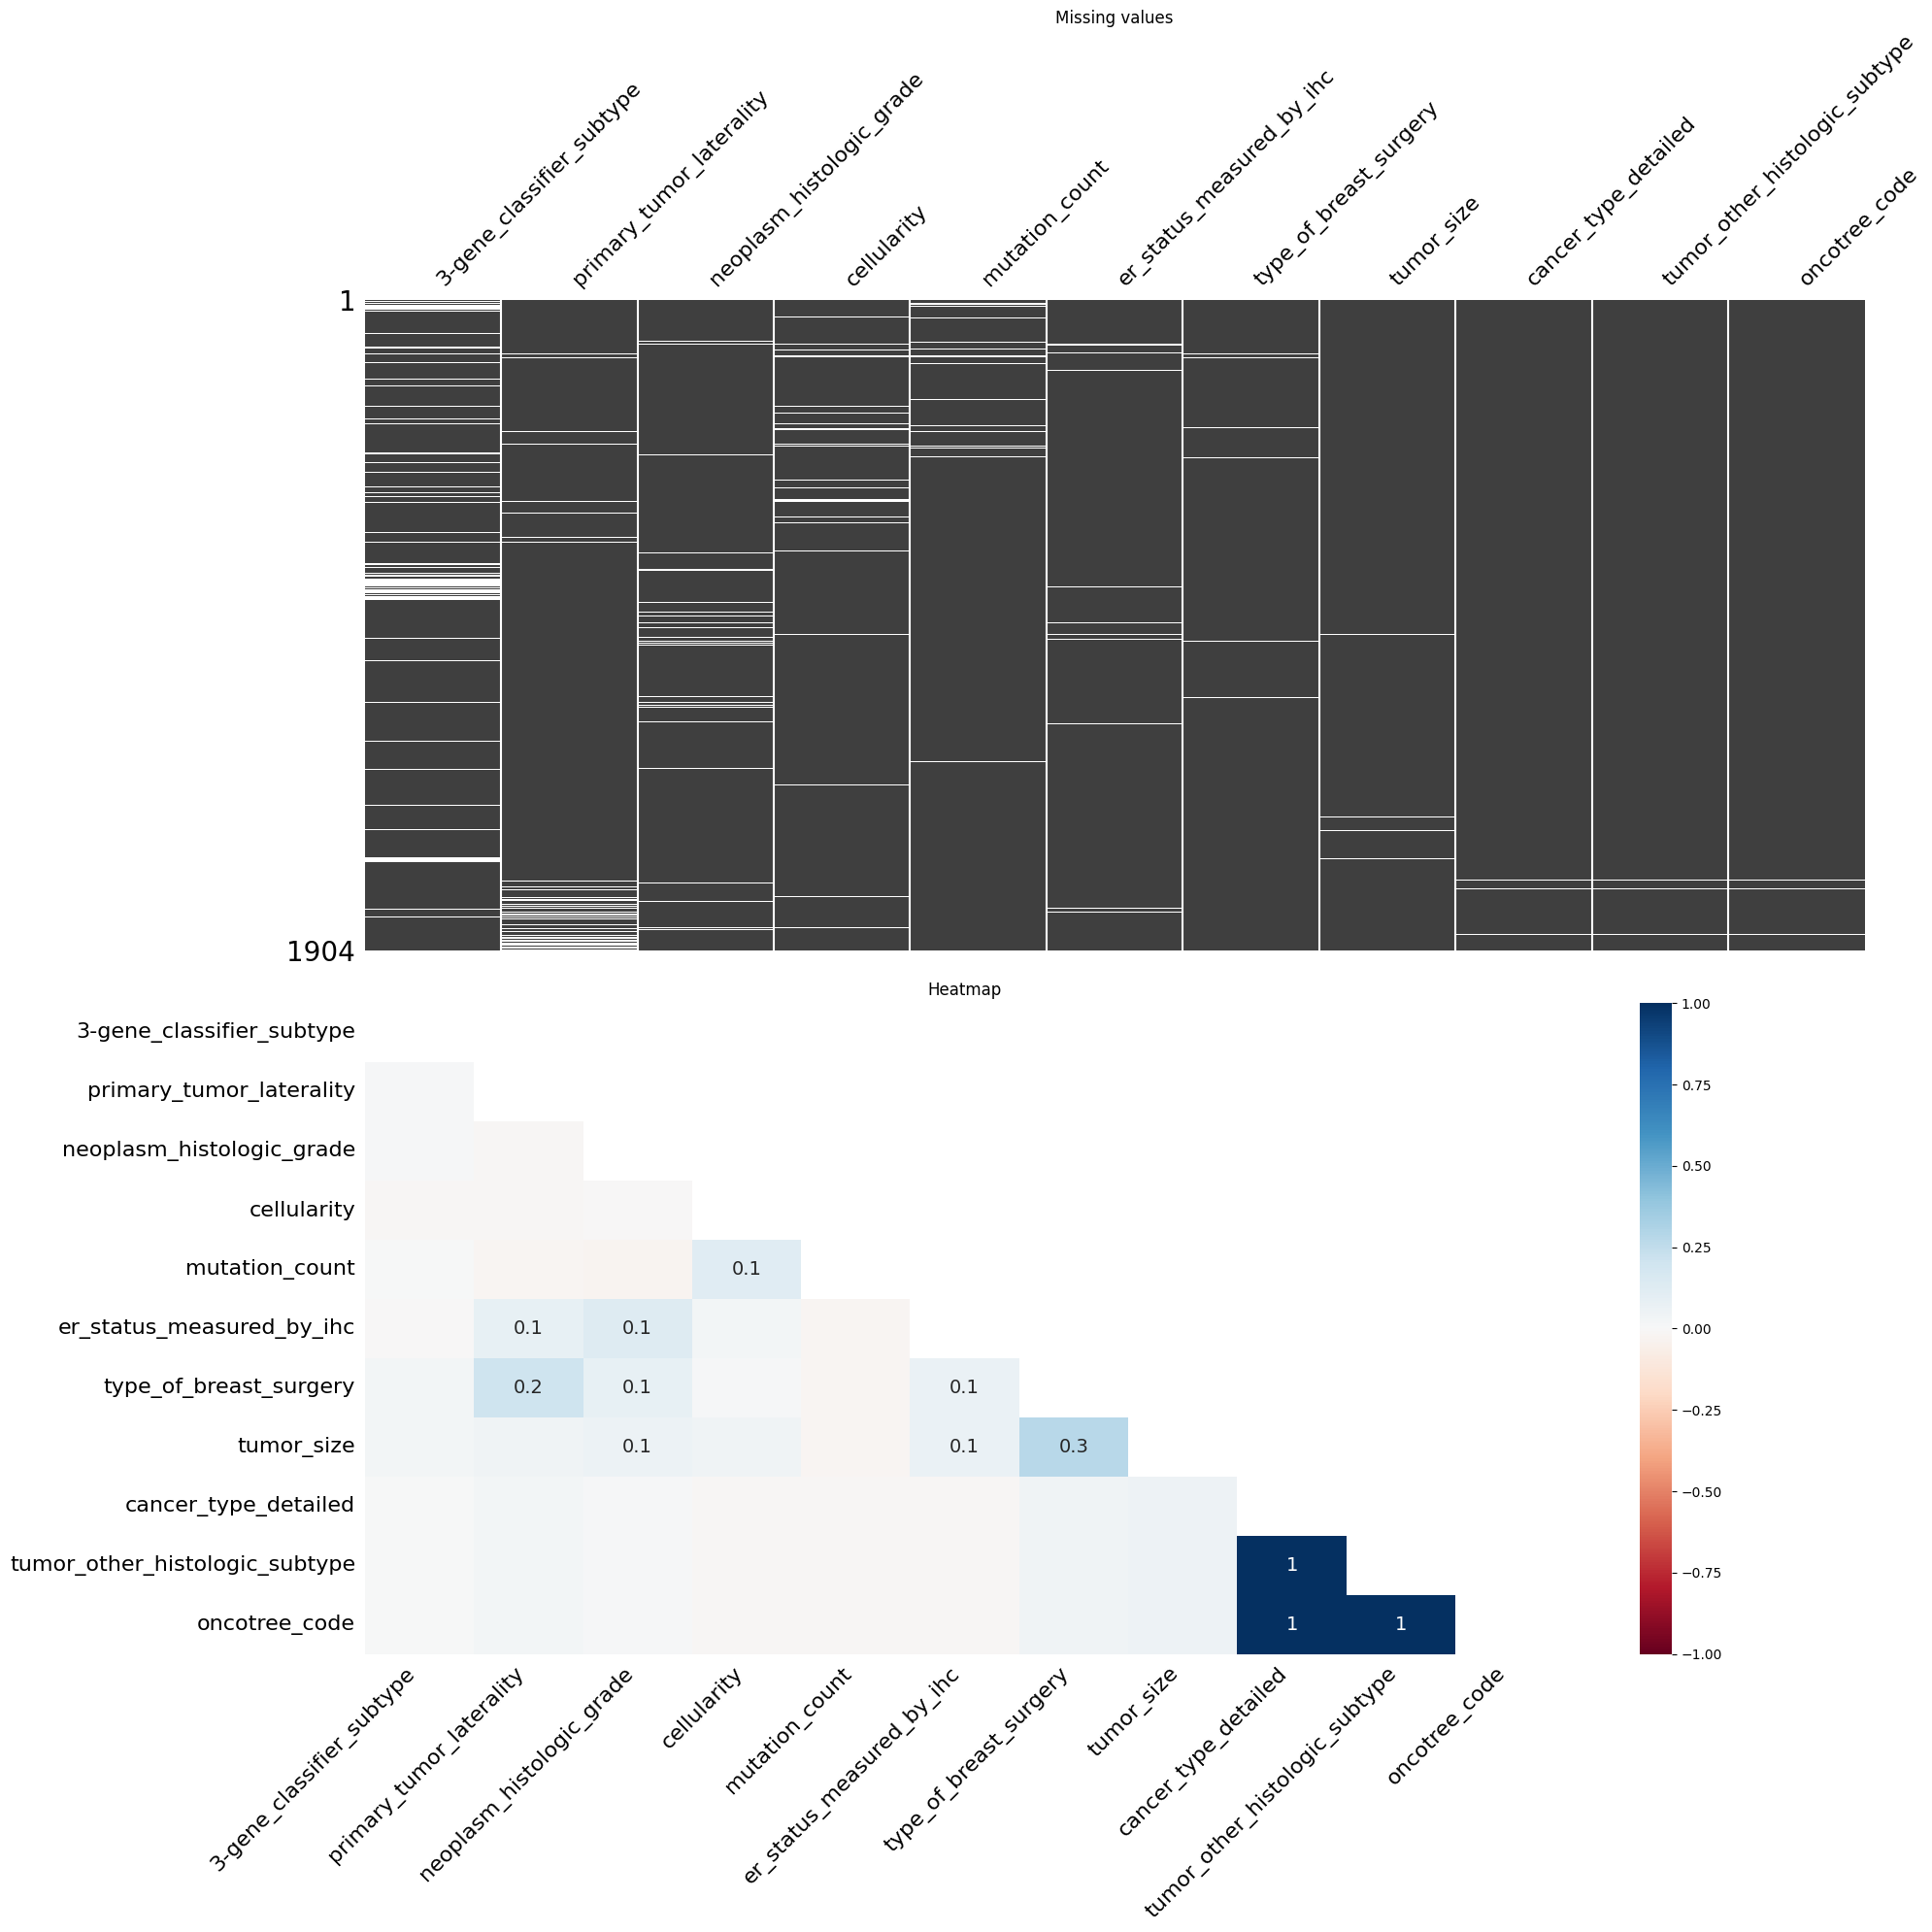

In [14]:
import missingno as msno

missing_data_cols=data[missing_data[missing_data['Total Missing Values']>0].index.tolist()].columns
fig, axes = plt.subplots(2, 1, figsize=(20, 20))
ax1 = msno.matrix(data[missing_data_cols], ax=axes[0], sparkline=False)
ax1.set_title("Missing values")
ax2 = msno.heatmap(data[missing_data_cols], ax=axes[1])
ax2.set_title("Heatmap")

fig.tight_layout()
plt.show()


1. The matrix shows that the **tumor_stage** and **3-gene_classifier_subtype** has most of the missing values but it doesnt have any correlation with any of the missing data columns, which means they occur completely at random
   *  but we need to consider the columns which didnt had any missing values, eg: tumor stage will have some correlation with radio therapy
   *  therefore these variables are likely to have some correlation with other feature columns , hence its not completely at random
3. Heatmap:
    * ```tumor_other_histologic_subtype``` & ```cancer_type_detailed``` & ```oncotree_code``` shows high correlation of 1 indicating that if one of the values in any of these columns are missing then the other column values will also be missing :**MNAR type**
    * from the matrix we can confirm that whenever one of these values are missing the other column values are also missing for the same row
    * this means that they are strongly linked in terms of missing data and we need to use only one of the columns( redundant columns)

In [15]:
# Replace the missing values by 'unknown' where 2 features have high missing % which can not be replaced by any means
cols_replace=['3-gene_classifier_subtype','primary_tumor_laterality']
data[cols_replace]=data[cols_replace].astype('object')
data.loc[:,cols_replace]=data.loc[:,cols_replace].fillna('unknown')
data[cols_replace]=data[cols_replace].astype('category')
# Remove the records from dataset where features have low missing values
cols_no_replace=['neoplasm_histologic_grade', 'cellularity','mutation_count','er_status_measured_by_ihc','type_of_breast_surgery','tumor_size','tumor_other_histologic_subtype','cancer_type_detailed','oncotree_code']
data.dropna(subset=cols_no_replace,inplace=True)

### Split train test data

In [16]:
X_train, X_test, y_train, y_test = train_test_split(data[cat_cols+num_cols+gene_mrna], data['overall_survival'], test_size=0.2, random_state=0)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((1341, 517), (336, 517), (1341,), (336,))

### Encode categorical feature variables

In [17]:
X_train.sample()

,tumor_stage,type_of_breast_surgery,cancer_type,cancer_type_detailed,cellularity,pam50_+_claudin-low_subtype,er_status_measured_by_ihc,er_status,her2_status_measured_by_snp6,her2_status,tumor_other_histologic_subtype,inferred_menopausal_state,primary_tumor_laterality,oncotree_code,pr_status,3-gene_classifier_subtype,age_at_diagnosis,integrative_cluster,chemotherapy,cohort,neoplasm_histologic_grade,hormone_therapy,lymph_nodes_examined_positive,mutation_count,nottingham_prognostic_index,overall_survival_months,radio_therapy,tumor_size,brca1,brca2,palb2,pten,tp53,atm,cdh1,chek2,nbn,nf1,stk11,bard1,mlh1,msh2,msh6,pms2,epcam,rad51c,rad51d,rad50,rb1,rbl1,rbl2,ccna1,ccnb1,cdk1,ccne1,cdk2,cdc25a,ccnd1,cdk4,cdk6,ccnd2,cdkn2a,cdkn2b,myc,cdkn1a,cdkn1b,e2f1,e2f2,e2f3,e2f4,e2f5,e2f6,e2f7,e2f8,src,jak1,jak2,stat1,stat2,stat3,stat5a,stat5b,mdm2,tp53bp1,adam10,adam17,aph1a,aph1b,arrdc1,cir1,ctbp1,ctbp2,cul1,dll1,dll3,dll4,dtx1,dtx2,dtx3,dtx4,ep300,fbxw7,hdac1,hdac2,hes1,hes5,heyl,itch,jag1,jag2,kdm5a,lfng,maml1,maml2,maml3,ncor2,ncstn,notch1,notch2,notch3,nrarp,numb,numbl,psen1,psen2,psenen,rbpj,rbpjl,rfng,snw1,spen,hes2,hes4,hes7,hey1,hey2,acvr1,acvr1b,acvr1c,acvr2a,acvr2b,acvrl1,akt1,akt1s1,akt2,apaf1,arl11,atr,aurka,bad,bcl2,bcl2l1,bmp10,bmp15,bmp2,bmp3,bmp4,bmp5,bmp6,bmp7,bmpr1a,bmpr1b,bmpr2,braf,casp10,casp3,casp6,casp7,casp8,casp9,chek1,csf1,csf1r,cxcl8,cxcr1,cxcr2,dab2,diras3,dlec1,dph1,egfr,eif4e,eif4ebp1,eif5a2,erbb2,erbb3,erbb4,fas,fgf1,fgfr1,folr1,folr2,folr3,foxo1,foxo3,gdf11,gdf2,gsk3b,hif1a,hla-g,hras,igf1,igf1r,inha,inhba,inhbc,itgav,itgb3,izumo1r,kdr,kit,kras,map2k1,map2k2,map2k3,map2k4,map2k5,map3k1,map3k3,map3k4,map3k5,mapk1,mapk12,mapk14,mapk3,mapk4,mapk6,mapk7,mapk8,mapk9,mdc1,mlst8,mmp1,mmp10,mmp11,mmp12,mmp13,mmp14,mmp15,mmp16,mmp17,mmp19,mmp2,mmp21,mmp23b,mmp24,mmp25,mmp26,mmp27,mmp28,mmp3,mmp7,mmp9,mtor,nfkb1,nfkb2,opcml,pdgfa,pdgfb,pdgfra,pdgfrb,pdpk1,peg3,pik3ca,pik3r1,pik3r2,plagl1,ptk2,rab25,rad51,raf1,rassf1,rheb,rictor,rps6,rps6ka1,rps6ka2,rps6kb1,rps6kb2,rptor,slc19a1,smad1,smad2,smad3,smad4,smad5,smad6,smad7,smad9,sptbn1,terc,tert,tgfb1,tgfb2,tgfb3,tgfbr1,tgfbr2,tgfbr3,tsc1,tsc2,vegfa,vegfb,wfdc2,wwox,zfyve9,arid1a,arid1b,cbfb,gata3,kmt2c,kmt2d,myh9,ncor1,pde4dip,ptprd,ros1,runx1,tbx3,abcb1,abcb11,abcc1,abcc10,bbc3,bmf,cyp2c8,cyp3a4,fgf2,fn1,map2,map4,mapt,nr1i2,slco1b3,tubb1,tubb4a,tubb4b,twist1,adgra2,afdn,aff2,agmo,agtr2,ahnak,ahnak2,akap9,alk,apc,arid2,arid5b,asxl1,asxl2,bap1,bcas3,birc6,cacna2d3,ccnd3,chd1,clk3,clrn2,col12a1,col22a1,col6a3,ctcf,ctnna1,ctnna3,dnah11,dnah2,dnah5,dtwd2,fam20c,fanca,fancd2,flt3,foxp1,frmd3,gh1,gldc,gpr32,gps2,hdac9,herc2,hist1h2bc,kdm3a,kdm6a,klrg1,l1cam,lama2,lamb3,large1,ldlrap1,lifr,lipi,magea8,map3k10,map3k13,men1,mtap,muc16,myo1a,myo3a,ncoa3,nek1,nf2,npnt,nr2f1,nr3c1,nras,nrg3,nt5e,or6a2,palld,pbrm1,ppp2cb,ppp2r2a,prkacg,prkce,prkcq,prkcz,prkg1,prps2,prr16,ptpn22,ptprm,rasgef1b,rpgr,ryr2,sbno1,setd1a,setd2,setdb1,sf3b1,sgcd,shank2,siah1,sik1,sik2,smarcb1,smarcc1,smarcc2,smarcd1,spaca1,stab2,stmn2,syne1,taf1,taf4b,tbl1xr1,tg,thada,thsd7a,ttyh1,ubr5,ush2a,usp9x,utrn,zfp36l1,ackr3,akr1c1,akr1c2,akr1c3,akr1c4,akt3,ar,bche,cdk8,cdkn2c,cyb5a,cyp11a1,cyp11b2,cyp17a1,cyp19a1,cyp21a2,cyp3a43,cyp3a5,cyp3a7,ddc,hes6,hsd17b1,hsd17b10,hsd17b11,hsd17b12,hsd17b13,hsd17b14,hsd17b2,hsd17b3,hsd17b4,hsd17b6,hsd17b7,hsd17b8,hsd3b1,hsd3b2,hsd3b7,mecom,met,ncoa2,nrip1,pik3r3,prkci,prkd1,ran,rdh5,sdc4,serpini1,shbg,slc29a1,sox9,spry2,srd5a1,srd5a2,srd5a3,st7,star,tnk2,tulp4,ugt2b15,ugt2b17,ugt2b7
patient_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,

In [18]:
# now for the feature columns, we convert categorical variables into multiple binary columns (one-hot encoding)
encoder = OneHotEncoder(handle_unknown='ignore', sparse_output=False,drop='first')
X_train_cat=encoder.fit_transform(X_train[cat_cols])
X_train_cat=pd.DataFrame(X_train_cat,columns=encoder.get_feature_names_out(),index=X_train.index)
X_test_cat=encoder.transform(X_test[cat_cols])
X_test_cat=pd.DataFrame(X_test_cat,columns=encoder.get_feature_names_out(),index=X_test.index)

Reasoning: Conversion of multiple levels of categorical variables into matrix of binary 0 and 1 values for all levels in the variable helps in reasoning the prediction and add the categorical variable as numeric into the model

### Scale the numeric features data

In [19]:
scaler=StandardScaler()
X_train_num=scaler.fit_transform(X_train[num_cols])
X_train_num=pd.DataFrame(X_train_num, columns=scaler.get_feature_names_out(),index=X_train.index)
X_test_num=scaler.transform(X_test[num_cols])
X_test_num=pd.DataFrame(X_test_num, columns=scaler.get_feature_names_out(),index=X_test.index)

Reasoning: Scaling of the numeric features by standard scaler helped in adjusting the different measurements of different variables to 0 mean and 1 standard deviation, will help in faster convergence of classification models with stable updates

### PCA transformation of gene mRNA levels data (gene expression data is standard scaled in original dataset)

In [20]:
pca = PCA(n_components=10,random_state=0)
X_train_pca = pca.fit_transform(X_train[gene_mrna])
X_train_pca=pd.DataFrame(X_train_pca, 
                         columns=['gene_mrna_level_pca0','gene_mrna_level_pca1','gene_mrna_level_pca2','gene_mrna_level_pca3','gene_mrna_level_pca4',
                                 'gene_mrna_level_pca5','gene_mrna_level_pca6','gene_mrna_level_pca7','gene_mrna_level_pca8','gene_mrna_level_pca9'],
                         index=X_train.index)
X_test_pca = pca.fit_transform(X_test[gene_mrna])
X_test_pca=pd.DataFrame(X_test_pca, 
                         columns=['gene_mrna_level_pca0','gene_mrna_level_pca1','gene_mrna_level_pca2','gene_mrna_level_pca3','gene_mrna_level_pca4',
                                 'gene_mrna_level_pca5','gene_mrna_level_pca6','gene_mrna_level_pca7','gene_mrna_level_pca8','gene_mrna_level_pca9'],
                         index=X_test.index)

Reasoning: The Principal Component Analysis will help in reduced dimensionality as our data contains 489 genes mRNA levels numeric features,
we can reduce them into few PCs' (Principal Components) to cover maximum variance without increasing dimensions. To balance both, only 10 PCs' 
considered.

In [21]:
X_train_pca.head()

,gene_mrna_level_pca0,gene_mrna_level_pca1,gene_mrna_level_pca2,gene_mrna_level_pca3,gene_mrna_level_pca4,gene_mrna_level_pca5,gene_mrna_level_pca6,gene_mrna_level_pca7,gene_mrna_level_pca8,gene_mrna_level_pca9
patient_id,,,,,,,,,,
2840,-1.429,-4.586,6.467,5.559,-2.304,1.684,-0.736,1.352,-3.509,0.990
2917,6.546,12.498,-2.989,6.748,-1.828,-0.246,2.097,2.459,-4.051,2.564
5540,0.450,2.814,-5.498,-1.094,-1.293,5.641,-2.088,-4.279,4.869,-2.968
4015,2.705,5.041,1.353,0.927,5.269,3.841,-1.709,4.239,2.415,0.650
5605,0.787,-3.137,-6.400,2.462,1.362,-5.747,8.540,3.849,2.456,-0.712


In [22]:
explained_variance = pca.explained_variance_ratio_
for i, var in enumerate(explained_variance[:10]):
    print(f"PC{i+1} explains {var:.2%} of the variance")
print('Total variance explained by the first 10 components is {}%'.format(round(np.sum(explained_variance)*100,2)))

PC1 explains 7.50% of the variance
PC2 explains 7.36% of the variance
PC3 explains 5.34% of the variance
PC4 explains 4.12% of the variance
PC5 explains 2.66% of the variance
PC6 explains 2.24% of the variance
PC7 explains 2.10% of the variance
PC8 explains 1.87% of the variance
PC9 explains 1.68% of the variance
PC10 explains 1.60% of the variance
Total variance explained by the first 10 components is 36.47%


## Preparing final train and test tables for modeling purpose

In [23]:
X_train_transformed=pd.concat([X_train_num, X_train_cat, X_train_pca],axis=1)
X_test_transformed=pd.concat([X_test_num, X_test_cat, X_test_pca],axis=1)

In [24]:
X_train_transformed.to_csv('./Dataset/X_train_transformed.csv',index=True)
X_test_transformed.to_csv('./Dataset/X_test_transformed.csv',index=True)
y_train.to_csv('./Dataset/y_train.csv',index=True)
y_test.to_csv('./Dataset/y_test.csv',index=True)

In [25]:
# Reading the data back for modeling
# X_train_new=pd.read_csv('./Dataset/X_train_transformed.csv',index_col=0)

## Write trained encoders and PCA model object for future use

In [26]:
joblib.dump(encoder, './Objects/OneHotEncoder.pkl')
joblib.dump(scaler, './Objects/StandardScaler.pkl')
joblib.dump(pca, './Objects/PCA.pkl')

['./Objects/PCA.pkl']